In [1]:
#import pandas
import pandas as pd

# To ignore warnings, use the following code to make the display more attractive.
# Import seaborn and matplotlib.
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", color_codes=True)
low_df = pd.read_excel('C:/Users/Max/Documents/MASTERS/CBTA_class_scripts/Excels/M4_Low_Birth_Weight_Data_Fix.xlsx')

low_df.head(5)

,LOW,AGE,LWT,RACE_WHITE,RACE_BLACK,RACE_OTHER,SMOKE,PTL,HT,UI,FTV
0,0,19,182,0,1,0,0,0,0,1,0
1,0,33,155,0,0,1,0,0,0,0,3
2,0,20,105,1,0,0,1,0,0,0,1
3,0,21,108,1,0,0,1,0,0,1,2
4,0,18,107,1,0,0,1,0,0,1,0


In [2]:
# Calculate churn statistics
low_stats = low_df['LOW'].value_counts().reset_index()
low_stats.columns = ['Low Birth Weight', 'Count']

# Calculate percentages
low_stats['Percentage'] = (low_stats['Count'] / low_stats['Count'].sum()) * 100


low_stats.head(3)

,Low Birth Weight,Count,Percentage
0,0,130,68.783069
1,1,59,31.216931


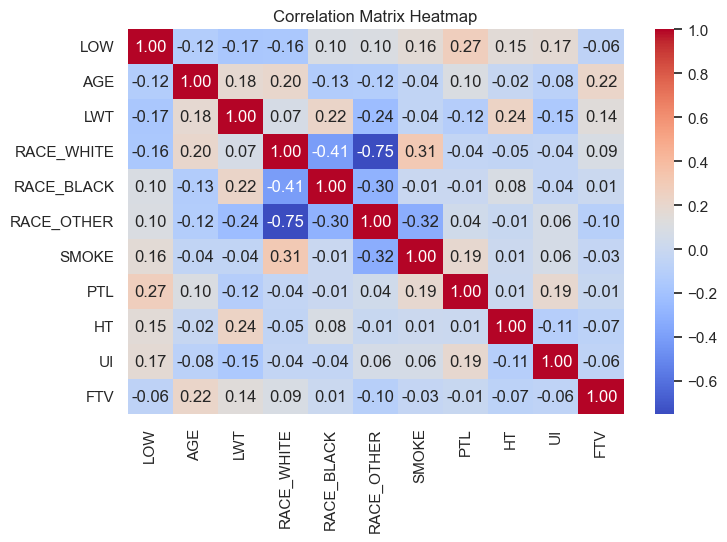

In [3]:
# Calculate correlation matrix -- trying to see which variables may impact churn
correlation_matrix = low_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 5))

# Create a heatmap to visualize the selected correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Set the title of the heatmap
plt.title("Correlation Matrix Heatmap")

# Show the heatmap
plt.show()


In [4]:
# Extract the correlation with the churn column
low_correlation = correlation_matrix['LOW'].sort_values(ascending=False)

low_correlation

LOW           1.000000
PTL           0.269813
UI            0.169043
SMOKE         0.161404
HT            0.152370
RACE_OTHER    0.097499
RACE_BLACK    0.095591
FTV          -0.062960
AGE          -0.118939
RACE_WHITE   -0.159152
LWT          -0.169627
Name: LOW, dtype: float64

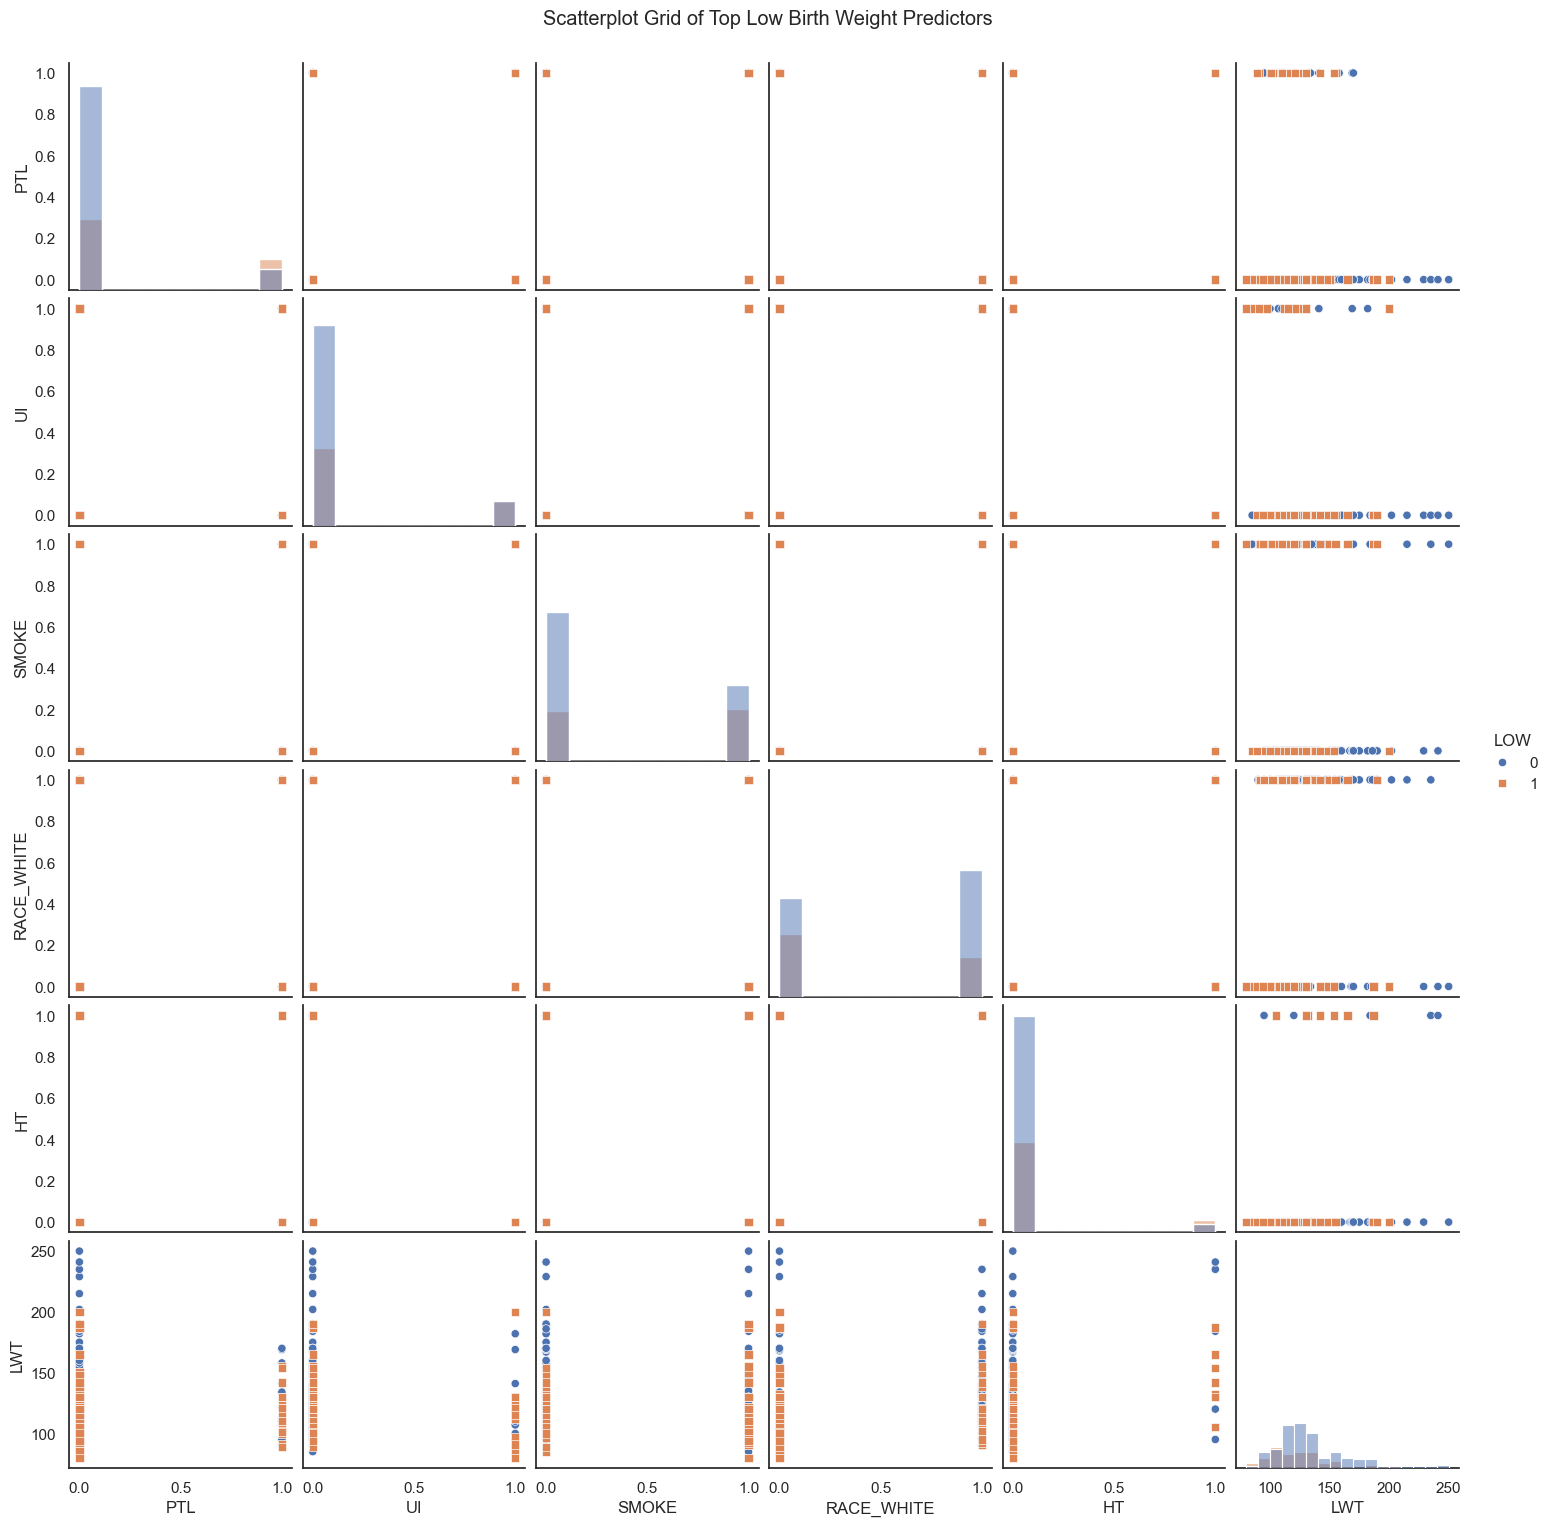

In [5]:
# Select the top predictors and the LOW column
top_predictors = ['PTL', 'UI', 'SMOKE','RACE_WHITE','HT','LWT','LOW']
predictors_df = low_df[top_predictors]

# Create a scatterplot grid
sns.pairplot(predictors_df, hue='LOW', diag_kind='hist', markers=["o", "s"])

# Display the plot
plt.suptitle('Scatterplot Grid of Top Low Birth Weight Predictors', y=1.02)
plt.show()

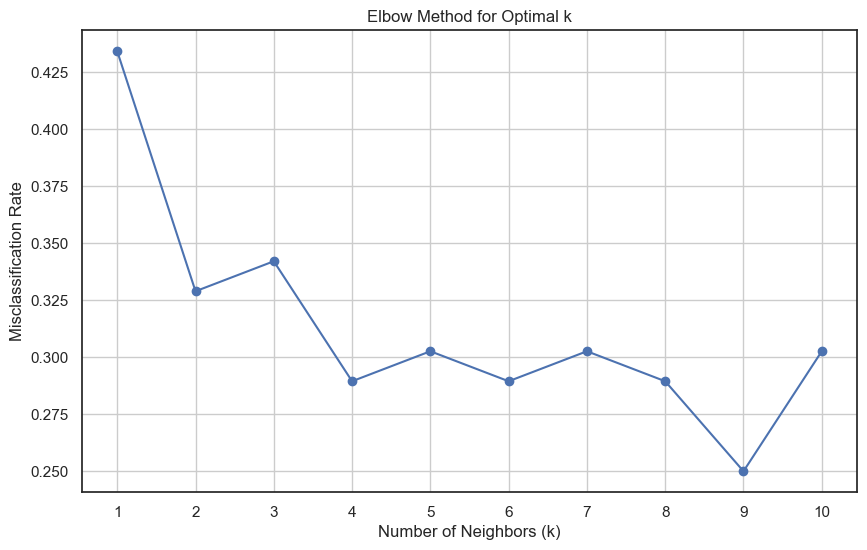

(9, 0.25)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define features and target variable
X = low_df.drop(columns=['LOW','RACE_OTHER','RACE_BLACK','FTV','AGE'])
y = low_df['LOW']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets (60% training, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Evaluate k-NN for k values from 1 to 10 using the elbow method
misclassification_rates = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    misclassification_rate = 1 - accuracy_score(y_test, y_pred)
    misclassification_rates.append(misclassification_rate)

# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), misclassification_rates, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Misclassification Rate')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Best k based on the elbow method
best_k = np.argmin(misclassification_rates) + 1
best_k, misclassification_rates[best_k - 1]


In [7]:
# Build and evaluate the final k-NN model with k=9
knn_best = KNeighborsClassifier(n_neighbors=9)
knn_best.fit(X_train, y_train)

# Predict on the test set
y_test_pred = knn_best.predict(X_test)

# Calculate the misclassification rate
misclassification_rate_best_k = 1 - accuracy_score(y_test, y_test_pred)

misclassification_rate_best_k


0.25

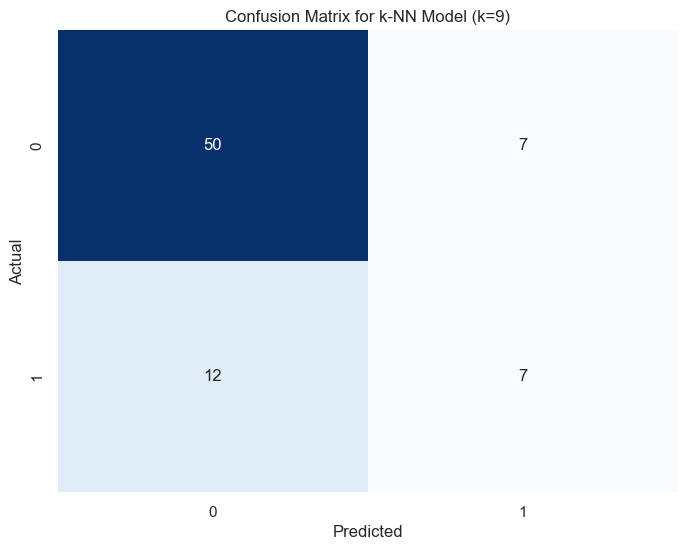

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for k-NN Model (k=9)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


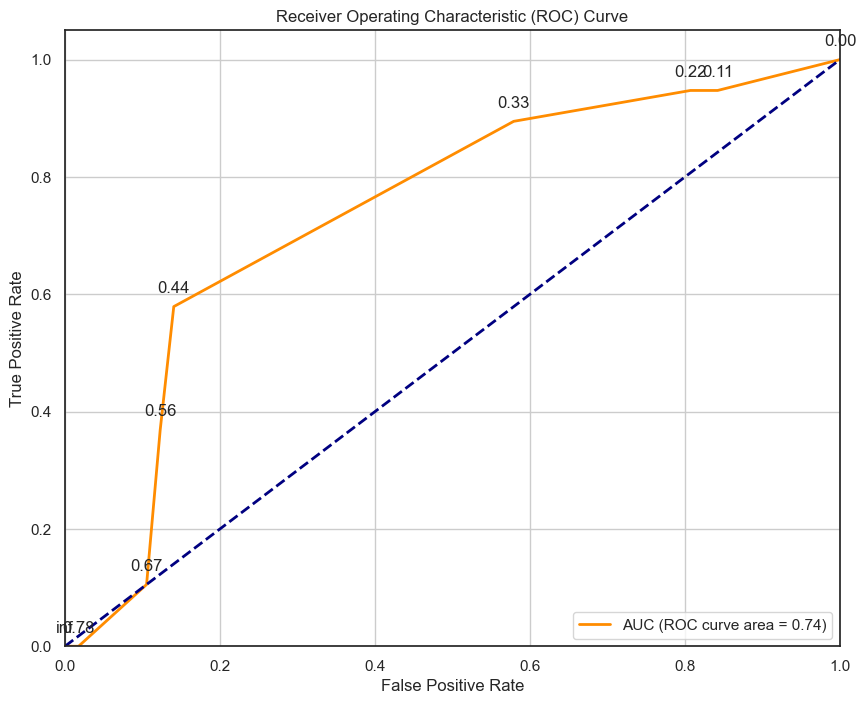

In [9]:
from sklearn.metrics import roc_curve, auc

# Get the probability scores for the positive class
y_test_prob = knn_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC (ROC curve area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Indicate threshold values on the curve
for i, thr in enumerate(thresholds):
    plt.annotate(f'{thr:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

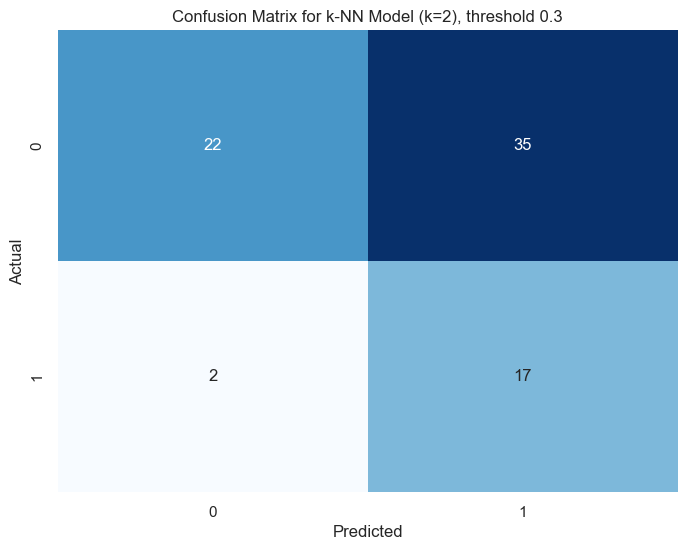

In [10]:
y_probs = knn.predict_proba(X_test)  # y_probs will be an array of shape (n_samples, n_classes)

# Define the custom threshold
threshold = 0.3 # Example threshold

# Apply the threshold to make predictions
# For binary classification, you can compare the probability of class 1 against the threshold
y_pred = (y_probs[:, 1] >= threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for k-NN Model (k=2), threshold 0.3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

